# Lego brick DCGAN
Get the lego bricks dataset [here](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images). We only care about the `dataset/` folder. Put it in this directory under `data/lego-brick-images/`.

[ganhacks](https://github.com/soumith/ganhacks)

In [5]:
# imports
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

## Load images into a dataset 


In [2]:
transform = transforms.Compose([transforms.Resize([64, 64]),
                                transforms.Grayscale(),
                                # scale between [0, 1]
                                transforms.ToTensor(), 
                                # subtract by 0.5, divide by 0.5, to get range [-1, 1] for tanh activation
                                transforms.Normalize(mean=0.5, std=0.5)])
dataset = datasets.ImageFolder('data/lego-brick-images/', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

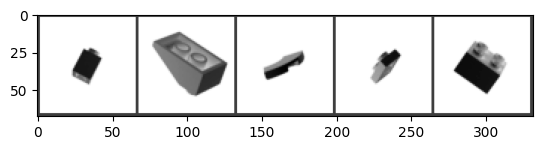

In [3]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(dataloader))
img_grid = torchvision.utils.make_grid(images[:5])
matplotlib_imshow(img_grid, one_channel=True)

## Build the Discriminator & Generator
note the DCGAN paper uses strided convolution rather than pooling to downsample saying it lets the network learn its own pooling function.

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 64x64 -> 32x32 
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 32x32 -> 16x16
            # note we set bias=False as BatchNorm will normalize bias https://ai.stackexchange.com/a/27742
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 16x16 -> 8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 8x8 -> 4x4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            # 4x4 -> 1x1
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False), # why no bias on last layer?
            # 0, 1 for classification
            nn.Sigmoid(),
            nn.Flatten()
        )  
    
    def forward(self, x):
        return self.main(x)

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential( # nn.Unflatten(0, (1, 1, 100)),
            # 1x1x100 -> 4x4x512
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, bias=False), # padding?
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(0.2),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1, momentum=0.9),
            nn.LeakyReLU(0.2),
            # tanh for stronger gradients
            nn.Tanh(),
        )  
    
    def forward(self, x):
        # add 2 dims to tensor with 100 params so we can use conv
        x = torch.reshape(x, (-1, 100, 1, 1)) # b, c, h, w
        return self.main(x)

## Training

In [24]:
discriminator = Discriminator()
generator = Generator()

loss_fn = torch.nn.BCELoss()

# individual optimizers for discrimination and generation
d_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) # specified in the DCGAN paper
g_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# labels for the discriminator
REAL, FAKE = 1., 0.

epochs = 5

In [33]:
for epoch in range(epochs):
    for batch_num, (real_images, _) in enumerate(dataloader, start=0):
        batch_size = real_images.shape[0]
        d_optim.zero_grad()
        g_optim.zero_grad()

        ### train discriminator
        # get loss for real images
        real_label = torch.full([batch_size, 1], REAL) # create tensor w/all real labels
        real_pred = discriminator(real_images)
        d_loss_real = loss_fn(real_pred, real_label)

        # generate fake images
        noise = torch.randn([batch_size, 100])
        fake_images = generator(noise)
        # get loss for fake images
        fake_label = torch.full([batch_size, 1], FAKE) # create tensor w/all fake labels
        fake_pred = discriminator(fake_images)
        d_loss_fake = loss_fn(fake_pred, fake_label)

        # backprop on discriminator
        d_loss = (d_loss_fake + d_loss_real) / 2.0
        d_loss.backward()       # maybe accumulate gradients instead?? https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#training
        d_optim.step()
        
        ### train generator 
        # the more the discriminator predicts that fake images are 
        # real, the lower the loss
        real_label = torch.full([batch_size, 1], REAL) 
        fake_images = generator(noise) # rerunning after discriminator is updated
        fake_pred = discriminator(fake_images)
        g_loss = loss_fn(fake_pred, real_label)
        g_loss.backward()
        g_optim.step()

        if batch_num % 10 == 0:
            print(f"\r[{epoch}/{epochs}] Batch {batch_num}/{len(dataloader)} d_loss:{d_loss.item():.4f} g_loss:{g_loss.item():.4f}", end='')

    print("")
    save_path = f"generator_ep{epoch}"
    torch.save(generator.state_dict(), save_path)

[2/5] Batch 30/313 d_loss:0.0000 g_loss:11.59029

KeyboardInterrupt: 

## Visual Evaluation

In [34]:
checkpoint = torch.load("generator_ep1")
generator.load_state_dict(checkpoint)

<All keys matched successfully>

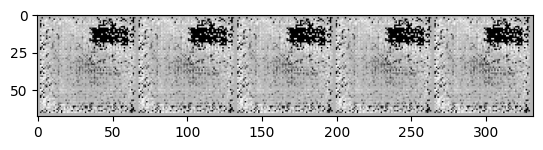

In [35]:
noise = torch.randn([128, 100])
images = generator(noise)
img_grid = torchvision.utils.make_grid(images[:5])
matplotlib_imshow(img_grid, one_channel=True)